# YOUR PROJECT TITLE

> **Note the following:** 
> 1. This is *not* meant to be an example of an actual **data analysis project**, just an example of how to structure such a project.
> 1. Remember the general advice on structuring and commenting your code
> 1. The `dataproject.py` file includes a function which can be used multiple times in this notebook.

Imports and set magics:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
#from matplotlib_venn import venn2

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# user written modules
import dataproject


# Read and clean data

Import your data, either through an API or manually, and load it. 

In [13]:
Elprice = pd.read_csv("Elspotprices.csv", delimiter=';') 
Consumption= pd.read_csv("ConsumptionDE35Hour.csv", delimiter=';')
#Consumption.HourDK.astype()
Consumption_DK1 = Consumption.loc[Consumption['PriceArea'] == 'DK1', :]
Elprice_DK1=Elprice.loc[Elprice['PriceArea'] == 'DK1', :]

Consumption_DK1_111 = Consumption_DK1.loc[Consumption_DK1["ConsumerType_DE35"] == 111, :]

#Consumption_DK1_111 
#Elprice_DK1

,HourUTC,HourDK,PriceArea,SpotPriceDKK,SpotPriceEUR
1,2023-03-30 21:00,2023-03-30 23:00,DK1,"676,190002","90,760002"
8,2023-03-30 20:00,2023-03-30 22:00,DK1,"735,570007","98,730003"
15,2023-03-30 19:00,2023-03-30 21:00,DK1,"763,289978","102,449997"
22,2023-03-30 18:00,2023-03-30 20:00,DK1,"867,960022","116,500000"
29,2023-03-30 17:00,2023-03-30 19:00,DK1,"891,809998","119,699997"
...,...,...,...,...,...
4999,2023-03-01 03:00,2023-03-01 04:00,DK1,"971,859985","130,580002"
5006,2023-03-01 02:00,2023-03-01 03:00,DK1,"950,119995","127,660004"
5013,2023-03-01 01:00,2023-03-01 02:00,DK1,"930,030029","124,959999"
5020,2023-03-01 00:00,2023-03-01 01:00,DK1,"933,750000","125,459999"


In [29]:
import datetime 
start_date = datetime.datetime(2023, 3, 20, 23, 0)
end_date = datetime.datetime(2023, 3, 1, 0, 0)

date_range = [start_date + datetime.timedelta(hours=i) for i in range((end_date - start_date).days * 24 + (end_date - start_date).seconds // 3600 + 1)]


[]

In [55]:
Time_C = Consumption_DK1_111['HourDK'] = pd.to_datetime(Consumption_DK1_111['HourDK'])
Time_P = Elprice_DK1['HourDK'] = pd.to_datetime(Elprice_DK1['HourDK'])

C111= Consumption_DK1_111['TotalCon'].values 
x = Elprice_DK1['SpotPriceDKK'].values 
# Replace commas with periods
string_price = [s.replace(',', '.') for s in x]
# Convert string vector to float vector
float_price = list(map(float, string_price))

#Consumption_DK1.describe()
#Consumption_DK1_111['HourDK']
#Consumption_DK1_111["TotalCon"]
#float_price = float_price.reset_index(drop=True)

# reset index for elprice in order to merge dataset 
# the index for float_price runs from 0-many for elprice there are leaps between 0 and 71 and so fourth due to dropping PriceAreas
Elprice_DK1 = Elprice_DK1.reset_index(drop=True)

Price_merged = pd.concat([Elprice_DK1, pd.DataFrame(float_price, columns=['float_price'])], axis=1)
Price_merged
#float_price




C:\Users\johan\AppData\Local\Temp\ipykernel_17100\3069269051.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Time_C = Consumption_DK1_111['HourDK'] = pd.to_datetime(Consumption_DK1_111['HourDK'])


,HourUTC,HourDK,PriceArea,SpotPriceDKK,SpotPriceEUR,float_price
0,2023-03-30 21:00,2023-03-30 23:00:00,DK1,"676,190002","90,760002",676.190002
1,2023-03-30 20:00,2023-03-30 22:00:00,DK1,"735,570007","98,730003",735.570007
2,2023-03-30 19:00,2023-03-30 21:00:00,DK1,"763,289978","102,449997",763.289978
3,2023-03-30 18:00,2023-03-30 20:00:00,DK1,"867,960022","116,500000",867.960022
4,2023-03-30 17:00,2023-03-30 19:00:00,DK1,"891,809998","119,699997",891.809998
...,...,...,...,...,...,...
714,2023-03-01 03:00,2023-03-01 04:00:00,DK1,"971,859985","130,580002",971.859985
715,2023-03-01 02:00,2023-03-01 03:00:00,DK1,"950,119995","127,660004",950.119995
716,2023-03-01 01:00,2023-03-01 02:00:00,DK1,"930,030029","124,959999",930.030029
717,2023-03-01 00:00,2023-03-01 01:00:00,DK1,"933,750000","125,459999",933.750000


In [65]:
merged = pd.merge(Price_merged, Consumption_DK1_111, on='HourDK')
merged.tail(10)

,HourUTC_x,HourDK,PriceArea_x,SpotPriceDKK,SpotPriceEUR,float_price,HourUTC_y,PriceArea_y,ConsumerType_DE35,TotalCon
709,2023-03-01 08:00,2023-03-01 09:00:00,DK1,"1137,979980","152,899994",1137.979980,2023-03-01 08:00,DK1,111,80728
710,2023-03-01 07:00,2023-03-01 08:00:00,DK1,"1384,550049","186,029999",1384.550049,2023-03-01 07:00,DK1,111,79064
711,2023-03-01 06:00,2023-03-01 07:00:00,DK1,"1384,550049","186,029999",1384.550049,2023-03-01 06:00,DK1,111,74748
712,2023-03-01 05:00,2023-03-01 06:00:00,DK1,"1216,489990","163,449997",1216.489990,2023-03-01 05:00,DK1,111,64580
713,2023-03-01 04:00,2023-03-01 05:00:00,DK1,"1052,010010","141,350006",1052.010010,2023-03-01 04:00,DK1,111,52639
714,2023-03-01 03:00,2023-03-01 04:00:00,DK1,"971,859985","130,580002",971.859985,2023-03-01 03:00,DK1,111,50224
715,2023-03-01 02:00,2023-03-01 03:00:00,DK1,"950,119995","127,660004",950.119995,2023-03-01 02:00,DK1,111,51134
716,2023-03-01 01:00,2023-03-01 02:00:00,DK1,"930,030029","124,959999",930.030029,2023-03-01 01:00,DK1,111,53025
717,2023-03-01 00:00,2023-03-01 01:00:00,DK1,"933,750000","125,459999",933.750000,2023-03-01 00:00,DK1,111,55799
718,2023-02-28 23:00,2023-03-01 00:00:00,DK1,"990,460022","133,080002",990.460022,2023-02-28 23:00,DK1,111,60245


Figure 1: Consumption in sector 111

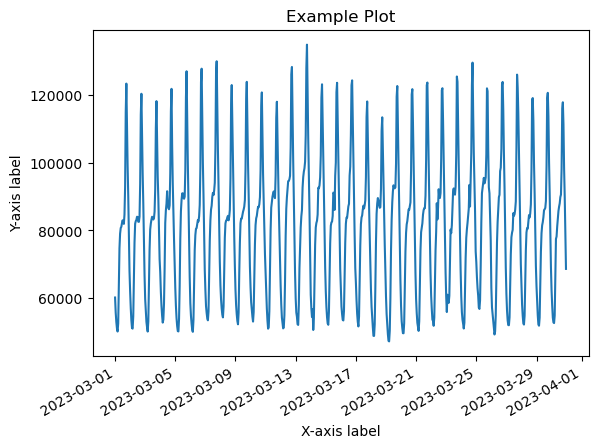

In [71]:
Consumption_DK1_111.plot(x="HourDK",y="TotalCon",legend=False);
# Add labels and title
plt.xlabel('X-axis label')
plt.ylabel('Y-axis label')
plt.title('Example Plot')

# Display the plot
plt.show()

Plot of price  

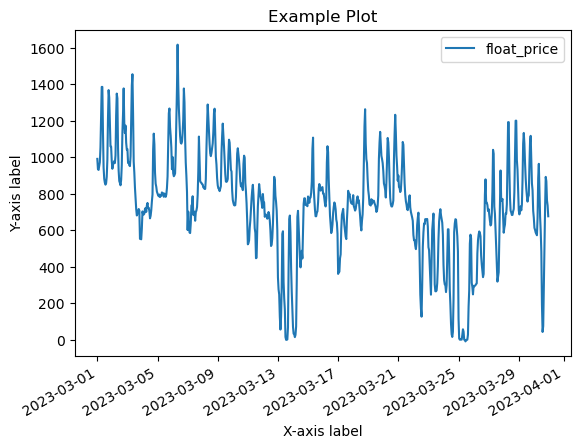

In [72]:

# Create a line plot
Price_merged.plot(x='HourDK', y="float_price")

# Add labels and title
plt.xlabel('X-axis label')
plt.ylabel('Y-axis label')
plt.title('Example Plot')

# Display the plot
plt.show()

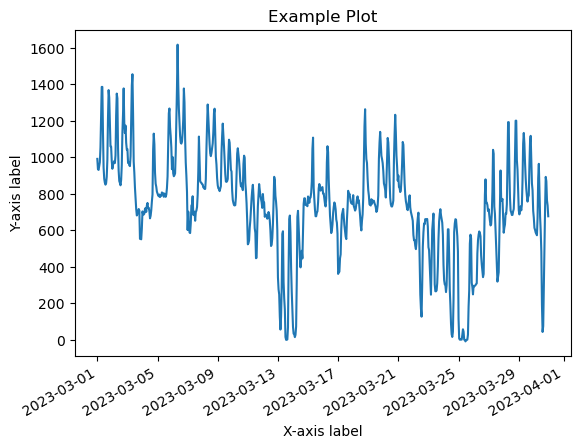

In [73]:
merged.plot(x="HourDK",y="float_price",legend=False);
# Add labels and title
plt.xlabel('X-axis label')
plt.ylabel('Y-axis label')
plt.title('Example Plot')

# Display the plot
plt.show()

C:\Users\johan\AppData\Local\Temp\ipykernel_17100\3589000864.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Consumption_DK1_111['Hour'] = Consumption_DK1_111['HourDK'].dt.hour
C:\Users\johan\AppData\Local\Temp\ipykernel_17100\3589000864.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Consumption_DK1_111['DayOfWeek'] = Consumption_DK1_111['HourDK'].dt.dayofweek
C:\Users\johan\AppData\Local\Temp\ipykernel_17100\3589000864.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

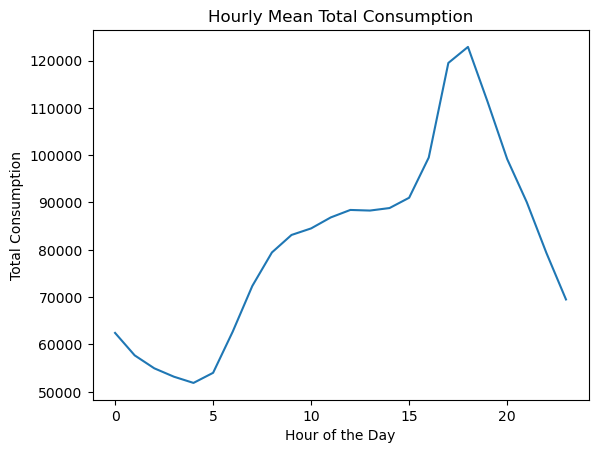

In [87]:
Consumption_DK1_111['Hour'] = Consumption_DK1_111['HourDK'].dt.hour
Consumption_DK1_111['DayOfWeek'] = Consumption_DK1_111['HourDK'].dt.dayofweek 
Consumption_DK1_111['Date'] = Consumption_DK1_111['HourDK'].dt.date

hourly_mean = Consumption_DK1_111.groupby(Consumption_DK1_111['HourDK'].dt.hour)['TotalCon'].mean()

# Plot the hourly mean values
fig, ax = plt.subplots()
ax.plot(hourly_mean.index, hourly_mean.values)

# Set the plot title and axis labels
ax.set_title('Hourly Mean Total Consumption')
ax.set_xlabel('Hour of the Day')
ax.set_ylabel('Total Consumption')

# Show the plot
plt.show()

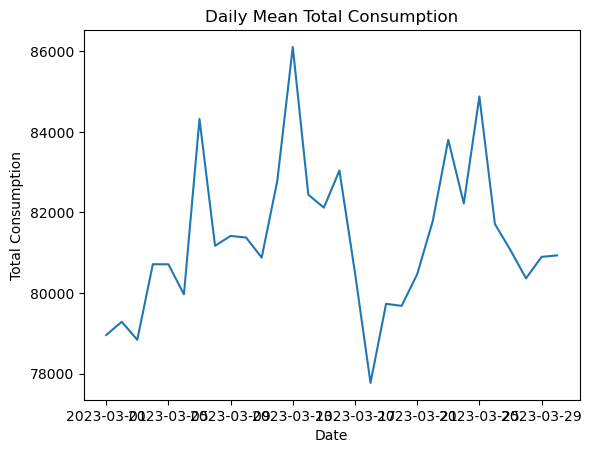

In [89]:
daily_mean = Consumption_DK1_111.groupby(Consumption_DK1_111['HourDK'].dt.date)['TotalCon'].mean()

# Plot the daily mean values
fig, ax = plt.subplots()
ax.plot(daily_mean.index, daily_mean.values)

# Set the plot title and axis labels
ax.set_title('Daily Mean Total Consumption')
ax.set_xlabel('Date')
ax.set_ylabel('Total Consumption')

# Show the plot
plt.show()

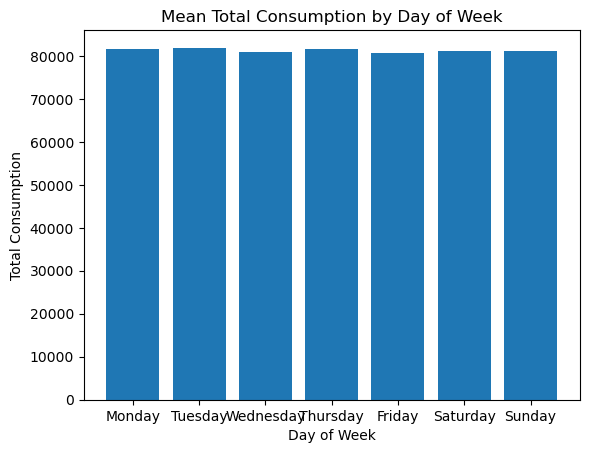

In [90]:
dayofweek_mean = Consumption_DK1_111.groupby(Consumption_DK1_111['HourDK'].dt.dayofweek)['TotalCon'].mean()

# Create a list of weekday names
weekday_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Plot the weekday mean values
fig, ax = plt.subplots()
ax.bar(weekday_names, dayofweek_mean)

# Set the plot title and axis labels
ax.set_title('Mean Total Consumption by Day of Week')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Total Consumption')

# Show the plot
plt.show()

## Explore each data set

In order to be able to **explore the raw data**, you may provide **static** and **interactive plots** to show important developments 

**Interactive plot** :

In [2]:
def plot_func():
    # Function that operates on data set
    pass

widgets.interact(plot_func, 
    # Let the widget interact with data through plot_func()    
); 


interactive(children=(Output(),), _dom_classes=('widget-interact',))

Explain what you see when moving elements of the interactive plot around. 

# Merge data sets

Now you create combinations of your loaded data sets. Remember the illustration of a (inner) **merge**:

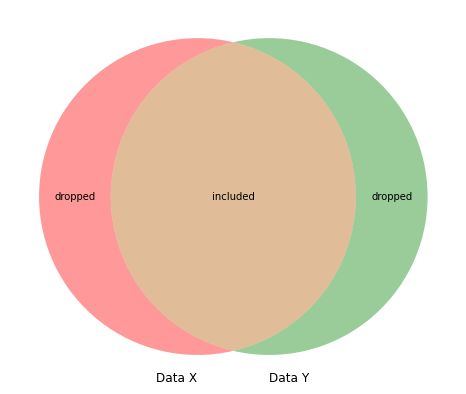

In [3]:
plt.figure(figsize=(15,7))
v = venn2(subsets = (4, 4, 10), set_labels = ('Data X', 'Data Y'))
v.get_label_by_id('100').set_text('dropped')
v.get_label_by_id('010').set_text('dropped' )
v.get_label_by_id('110').set_text('included')
plt.show()

Here we are dropping elements from both data set X and data set Y. A left join would keep all observations in data X intact and subset only from Y. 

Make sure that your resulting data sets have the correct number of rows and columns. That is, be clear about which observations are thrown away. 

**Note:** Don't make Venn diagrams in your own data project. It is just for exposition. 

# Analysis

To get a quick overview of the data, we show some **summary statistics** on a meaningful aggregation. 

MAKE FURTHER ANALYSIS. EXPLAIN THE CODE BRIEFLY AND SUMMARIZE THE RESULTS.

# Conclusion

ADD CONCISE CONLUSION.